In [1]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
from load_models import *
import matplotlib.pyplot as plt
import torch
import openml
from data_prep_utils import *
import matplotlib.pyplot as plt
from datetime import datetime
from tabpfn_new import priors, encoders
from tabpfn_new.scripts.model_configs import *
from tabpfn_new.scripts.model_builder import get_forest_prior_hyperparameters, get_mlp_prior_hyperparameters, get_model
from tabpfn.utils import get_uniform_single_eval_pos_sampler
from utils import get_dataloader
device = "cpu"

In [2]:
def reload_config(prior_type='forest', config_type='causal', task_type='binary', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'] = prior_type
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

In [3]:
def dl_from_config(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=0)
    dl = dl_class(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return dl

                                     
def get_sample(dl):
    (style, x, y), _, _ =  next(iter(dl))
    return x, y
    
def plot_grid(dl, hyperparameters, rows=8, cols=6):
    fig, axes = plt.subplots(rows, cols, figsize=(20,15))
    class_assigner = priors.flexible_categorical.BalancedBinarize()#priors.flexible_categorical.MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    for ax in axes.flatten():
        x2, b = get_sample(dl)
        #b = class_assigner(b)
        i1, i2 = np.random.choice(x2.shape[2], size=(2,), replace=False)
        ax.scatter(x2[:, 0, i1], x2[:, 0, i2], c=b, s=1.5, cmap="bwr")

def remove_zero_features(x):
    x = x[:,:,torch.where(torch.sum(torch.abs(x), dim=0)>0,1,0)]
    return x

def plot_feature_combinations(dl, hyperparameters, num_plots=10):
    fig = plt.figure(figsize=(20,15))
    x2, b = get_sample(dl)
    #x2 = remove_zero_features(x2)
    #class_assigner = priors.flexible_categorical.BalancedBinarize()#MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    #b = class_assigner(b)
    n_feat = num_plots#hyperparameters["max_features"]
    for i in range(n_feat-1):
        for j in range(n_feat):
            if(j>i) :
                ax = plt.subplot2grid((n_feat-1, n_feat-1), (i,j-1))
                #ax.xaxis.set_ticklabels([]) 
                #ax.yaxis.set_ticklabels([])
                plt.scatter(x2[:,0,i],x2[:,0,j],c=b, s=1.5, cmap="bwr")
    
    fig.show()

In [4]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['differentiable'] = True
config['flexible'] = True
config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.0
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']



config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = 0 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .0 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = True # False heisst eig True

config['n_layers'] = 4
config['emsize'] = 128
config['nhead'] = config['emsize'] // 32
config['bptt'] = 1024+128
config['canonical_y_encoder'] = True

    
config['aggregate_k_gradients'] = 1
config['batch_size'] = 1*config['aggregate_k_gradients']
config['num_steps'] = 1//config['aggregate_k_gradients']
config['epochs'] = 1

config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

# mlp params
config['is_causal'] = True
config['num_causes'] = 5
config['prior_mlp_hidden_dim'] = 50
config['num_layers'] = 4
config['noise_std'] = 0.05
config['init_std'] = 0.05
config['y_is_effect'] = True
config['pre_sample_weights'] = True
config['prior_mlp_dropout_prob'] = 0
config['pre_sample_causes'] = True
config["prior_mlp_activations"] = torch.nn.ReLU
config["block_wise_dropout"] = True
config["sort_features"] = False
config["in_clique"] = False

# general data params
config['balanced'] = True
config['max_num_classes'] = 2
config['max_features'] = 100
config['num_features_used'] = 100

config['num_classes'] = 2

config['no_encoder'] = False
config['normalize_to_ranking'] = False # False
config['normalize_with_sqrt'] = False
config['normalize_ignore_label_too'] = False
config["normalize"] = False
config['num_classes'] = 2
config["balanced"] = False
config['multiclass_type'] = 'imbalanced_binarize'


config_sample = evaluate_hypers(config)



In [ ]:
#dl = dl_from_config(config_sample, prior_hyperparameters)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]

In [ ]:
plot_grid(dl,config_sample)

In [ ]:
plot_feature_combinations(dl,config_sample)

In [ ]:
from torch.utils.data import DataLoader
class MicroDL(DataLoader):
    def __init__(self, path=None):
        data, labels = get_microbiome(path)
        data = top_non_zero(data)
        data, labels = unison_shuffled_copies(data, labels)
        self.data = data
        self.labels = labels

    def __len__(self):
        return 100
        
    def get_perm(self):
        indices = np.random.permutation(self.data.shape[0])[:1000]
        return (None, np.expand_dims(self.data[indices], axis=1), np.expand_dims(self.labels[indices],axis=1)), None, None
        
    def __iter__(self):
        indices = np.random.permutation(self.data.shape[0])[:1000]
        return iter(self.get_perm() for _ in range(100))
path = "datasets/data_all.csv"
dl = MicroDL(path)
#plot_grid(dl, config_sample)
plot_feature_combinations(dl, config_sample)

In [5]:
config['differentiable'] = True
config['flexible'] = True

# forest params
config["min_features"] = 100
config["max_features"] = 100
config["n_samples"] = 1000
config["max_classes"] = 2
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 3
config["max_depth"] = 15
config["categorical_x"] = False
config["data_sample_func"] = "zinb"
config["comp"] = True

config['multiclass_type'] = 'balance'
del config['differentiable_hyperparameters']['multiclass_type']

config["prior_type"] = "forest"
config["microbiome_test"] = True
config["weight_classes"] = False
config["run_name"] = "time"

config["prior_type"] = "forest"

In [ ]:
config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]
plot_grid(dl, config_sample)
plot_feature_combinations(dl, config_sample)

In [ ]:
config["data_sample_func"] = "mnd"


config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]

In [ ]:
plot_grid(dl, config_sample)
plot_feature_combinations(dl, config_sample)

In [ ]:
from tabpfn import TabPFNClassifier
model = TabPFNClassifier(device='cpu', N_ensemble_configurations=1)
x, y = get_sample(dl)
x, y = torch.squeeze(x), torch.squeeze(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(torch.tensor(preds)*y_test+(torch.tensor(preds)-1)*(y_test-1))

In [16]:
config["prior_type"] = "mlp"
config["sampling"] = "mnd"
config["data_sample_func"] = "mnd"
config["is_causal"] = False
config['multiclass_type'] = 'balance'
config['hist_targets'] = False

config["align_majority"] = False
config["limit_imbalance"] = False

config["normalize"] = True
config["num_classes"] = 2
config["max_num_classes"] = 2

config['min_depth'] = 5
config['max_depth'] = 15
#del config['differentiable_hyperparameters']['multiclass_type']

config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]

Using style prior: True
Using cpu:0 device
Using a Transformer with 1.64 M parameters


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [18]:
for i in range(100):
    print(f"\n\n\nRun #{i}")
    x, y = get_sample(dl)
    x, y = torch.squeeze(x), torch.squeeze(y)
    print("Target mean: ", torch.mean(y))
    if len(np.unique(y, return_counts=True)[0])>1 and np.min(np.unique(y, return_counts=True)[1])>20:
        #plt.hist(y, bins=100)
        #plt.show()
        cv = 3
        n_optim = 20
        ft_epochs = 0
        sampling = None
        strat_split=True
        metrics = metrics = ["accuracy", "precision", "recall", "roc_auc"]
        models = [
            #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
            XGBoostOptim(n_optim=n_optim),
            #LogisticRegression(max_iter=500), 
            #TabPFNClassifier(device='cpu', N_ensemble_configurations=3),
            #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml")
        ]
        results = pd.DataFrame(np.zeros((len(models), len(metrics))), 
                               index=[m.__class__.__name__ for m in models],
                              columns=metrics)
        
        for ii, model in enumerate(models):
            results.iloc[ii,:] = cross_validate_sample(model, x, y, metrics, strat_split, cv, sampling)
        print(results)




Run #0
Target mean:  tensor(0.5000)


C:\Users\lenna\Desktop\MT\TabPFN-medical\evaluate.py:22: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(c0_data)
C:\Users\lenna\Desktop\MT\TabPFN-medical\evaluate.py:23: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(c1_data)


ValueError: setting an array element with a sequence.

Using style prior: True
Using cpu:0 device
Using a Transformer with 1.64 M parameters


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


ROC:  0.7360507132182651 0.14917785094406735
Pred avgs:  0.6178100018948317


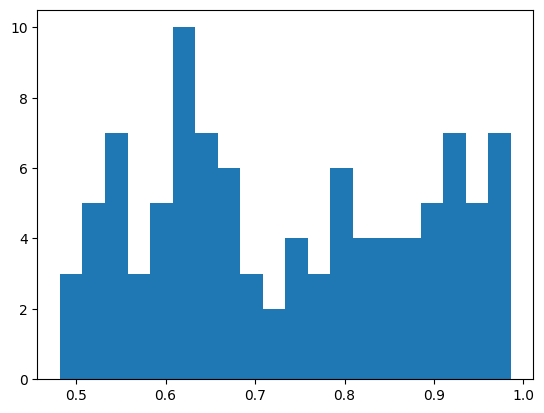

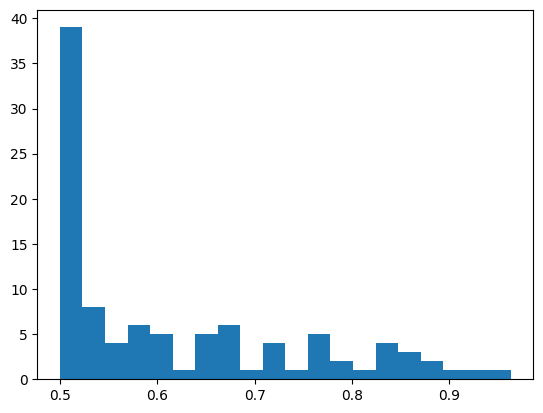

In [32]:
config["prior_type"] = "forest"
config["sampling"] = "mnd"
config["data_sample_func"] = "mnd"
config["is_causal"] = False
config['multiclass_type'] = 'balance'
config['hist_targets'] = False
config['y_std'] = 1
config['min_depth'] = 5
config['max_depth'] = 15
config['num_classes'] = 2


config["align_majority"] = False
config["limit_imbalance"] = False



config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]
rocs = []
means = []
for i in range(100):
    #print(f"\n\n\nRun #{i}")
    x, y = get_sample(dl)
    x, y = torch.squeeze(x).numpy(), torch.squeeze(y).numpy()
    #print(np.unique(y, return_counts=True))
    if len(np.unique(y, return_counts=True)[0])>1 and np.min(np.unique(y, return_counts=True)[1])>10:
        #print("Target mean: ", torch.mean(y))
        #plt.hist(y, bins=100)
        #plt.show()
        cv = 3
        n_optim = 20
        ft_epochs = 0
        sampling = None
        strat_split=True
        metrics = metrics = ["roc_auc"]#"roc_auc_ovr"]
        if config['num_classes'] ==2:
            o = 'binary:logistic'
        else:
            o = 'multi:softmax'
        model = XGBClassifier(n_estimators=7, max_depth=7, learning_rate=1, objective=o)#
        #model = XGBoostOptim(n_optim=n_optim)
        results = cross_validate_sample(model, x, y, metrics, strat_split, cv, sampling)
        means.append(max(1-np.mean(y),np.mean(y)))
        #print(results[0])
        rocs.append(results[0])
print("ROC: ", np.mean(np.array(rocs)), np.std(np.array(rocs)))
print("Pred avgs: ", np.mean(np.array(means)))
#result_matrix[ii,jj] = np.mean(np.array(rocs))
plt.hist(rocs, bins=20)
plt.show()
plt.hist(means, bins=20)
plt.show()

In [31]:
accs = []
for i in range(1000):
    #print(f"\n\n\nRun #{i}")
    x, y = get_sample(dl)
    x, y = torch.squeeze(x), torch.squeeze(y)
    preds = torch.full(y.shape, torch.argmax(torch.unique(y, return_counts=True)[1]).item())
    accuracy = torch.mean((preds==y)[y!=-100].float())
    accs.append(accuracy)
print(torch.mean(torch.tensor(accs)))

tensor(0.5005)


In [ ]:
for i in range(50,100,1):
    print(f"ROC sub {i*0.01} pred",  np.mean(np.array(rocs)[np.array(means)<i*0.01]), len(np.array(rocs)[np.array(means)<i*0.01])/len(means))

In [ ]:
print(result_matrix)

In [ ]:
plt.scatter(means,rocs)

In [ ]:
def multinomial_dirichlet(size=(1000,100)):
    M = 1000
    alphas = np.random.beta(1,1,size[1])
    thetas = [np.random.dirichlet(alphas) for i in range(size[0])]
    #print(thetas, np.sum(thetas))
    X = np.asarray([np.random.multinomial(M, theta)/M for theta in thetas])
    return X
X = multinomial_dirichlet()
print(X[:3])

In [ ]:
'''def get_sample(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    ''extra_prior_kwargs_dict={
        'num_features': config['num_features'], 
        'hyperparameters': prior_hyperparameters
    }
    extra_kwargs = {}
    if 'flexible' in config and config['flexible']:
        get_batch_base = make_get_batch(model_proto)
        extra_kwargs['get_batch'] = get_batch_base
        model_proto = priors.flexible_categorical
    if 'differentiable' in prior_hyperparameters and prior_hyperparameters['differentiable']:
        get_batch_base = make_get_batch(model_proto, **extra_kwargs)
        extra_kwargs = {'get_batch': get_batch_base, 'differentiable_hyperparameters': prior_hyperparameters['differentiable_hyperparameters']}
        model_proto = priors.differentiable_prior
        use_style = True
    
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_prior_kwargs_dict)''
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=2)
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return next(iter(dl))'''

In [ ]:
a = get_sample(config_sample, prior_hyperparameters)
print(a[0][1].shape)

In [ ]:
config['differentiable'] = False
config['flexible'] = False

# forest params
config["min_features"] = 10
config["max_features"] = 100
config["n_samples"] = 1000
config["max_classes"] = 10
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False

In [ ]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from evaluate import scores
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
import matplotlib.pyplot as plt
import torch
import openml
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest

In [ ]:
from tabularbench.data.synthetic_generator_tabpfn import synthetic_dataset_generator_tabpfn

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_tabpfn(n_samples=1000, max_classes=2, min_features=2, max_features=100)

for ax in axes.flatten():
    x2, b = next(generator)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    ax.scatter(x2[:, i1], x2[:, i2], c=b)

In [ ]:
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest
import matplotlib

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_forest(n_samples=1000, max_classes=2, min_features=2, max_features=2)

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))

for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [ ]:
def zinb(size=(1000,100)):
    pi = 0.25
    p = np.random.uniform(0.1,0.9, size=size[1])
    p = np.repeat(np.expand_dims(p,axis=0),size[0],axis=0)
    #print
    #p += 1e-5
    X = np.random.negative_binomial(100,p)
    X = np.random.binomial(1,1-pi,size)*X
    return X

In [ ]:
def zinb_comp(size=(1000,100)):
    X =  zinb(size)
    print(X)
    print(np.expand_dims(1/np.sum(X,axis=1),axis=1))
    return np.expand_dims(1/np.sum(X,axis=1),axis=1)*X

In [ ]:
out = zinb_comp((10,10))
print(out)

In [ ]:
print(np.sum(out, axis=1))

In [ ]:
from prior.synthetic_generator_forest_altdata import synthetic_dataset_generator_forest_altdata, synthetic_dataset_function_forest_altdata

fig, axes = plt.subplots(8, 6, figsize=(20, 15))

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))



for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [ ]:

X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_norm, b_norm, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    print(ii)
    X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_zinb, b_zinb, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)